In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.util import testData
import src.model.reserve_market_functionality as rmf
import src.model.power_market_functionality as pmf

In [2]:
df = testData().loc["2019-03-12":"2019-03-13"]

# Create Network

In [3]:
components = pypsa.components.components.copy()

component_attrs = dict({k: v.copy() for k, v in pypsa.components.component_attrs.items()})
rmf.add_reserve_to_component_attrs(component_attrs)
rmf.add_reserve_market_to_component_attrs(components, component_attrs)
pmf.add_power_market_to_component_attrs(component_attrs)

In [4]:
def createGeneratorAndBESSNetwork(n):
    n.add("Bus","bus1")
    n.add("Bus","bus2")
    n.add("Bus","busb")
    n.add("Generator","gen1",bus="bus1",p_nom=100, marginal_cost=10, reserve_pos_max=100, reserve_neg_max=100)

    eta=0.9797
    n.add("Link","eleccharge", bus0 = "bus1", bus1 = "busb", p_nom = 6, efficiency = eta)
    n.add("Link","elecdischarge", bus0 = "busb", bus1 = "bus1", p_nom = 6, efficiency = eta)
    n.add("StorageUnit","bat", bus="busb", state_of_charge_initial=10,p_nom=20,standing_loss = 0,p_min_pu=-1,reserve_pos_max=20, reserve_neg_max=20)

    n.add("Generator","da",bus="bus2",marginal_cost=df["da_EUR_MWh"],is_market=True, include_bids=True, p_min_pu=-1,p_nom=np.inf)
    n.add("aFRR_Market","aFRR",marginal_cost_pos=df["aFRR_pos_EUR_MW"],marginal_cost_neg=df["aFRR_neg_EUR_MW"],include_bids=True)

    n.add("Link","link1",bus0="bus1",bus1="bus2",p_nom=1000)

In [5]:
snapshots = df.index
n = pypsa.Network(snapshots=snapshots,override_components=components,override_component_attrs=component_attrs)
createGeneratorAndBESSNetwork(n)

In [6]:
def extra_functionality(n: pypsa.Network, sn):
    rmf.add_reserve_market_to_model(n)
    pmf.add_power_market_to_model(n)

# Run Optimization

In [7]:
n.optimize(extra_functionality=extra_functionality)

Index(['eleccharge', 'elecdischarge', 'link1'], dtype='object', name='Link')
Index(['bus1', 'bus2', 'busb'], dtype='object', name='Bus')
Index(['eleccharge', 'elecdischarge', 'link1'], dtype='object', name='Link')
Index(['bus1', 'bus2', 'busb'], dtype='object', name='Bus')
/home/tom/Dokumente/Uni/HIWI/PyPSA-stochUC/.env/lib/python3.10/site-packages/linopy/common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.08s
INFO:linopy.solvers:Log file at /tmp/highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2256 primals, 1898 duals
Objective: -1.65e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shado

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e-02, 8e+01]
  Bound  [2e+01, 1e+02]
  RHS    [6e+00, 1e+03]
Presolving model
622 rows, 576 cols, 1726 nonzeros  0s
499 rows, 453 cols, 1819 nonzeros  0s
478 rows, 407 cols, 1721 nonzeros  0s
Presolve : Reductions: rows 478(-1420); columns 407(-1849); elements 1721(-2598)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     5.4260088792e-09 Ph1: 285(284858); Du: 0(3.54808e-11) 0s
        302    -1.6492080577e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 302
Objective value     : -1.6492080577e+05
HiGHS run time      :          0.01
Writing the solution to /tmp/linopy-solve-dmyep9ei.sol


('ok', 'optimal')

# Plot Results
## Power of Generators and Storage Units

Text(0, 0.5, 'Power [MW]')

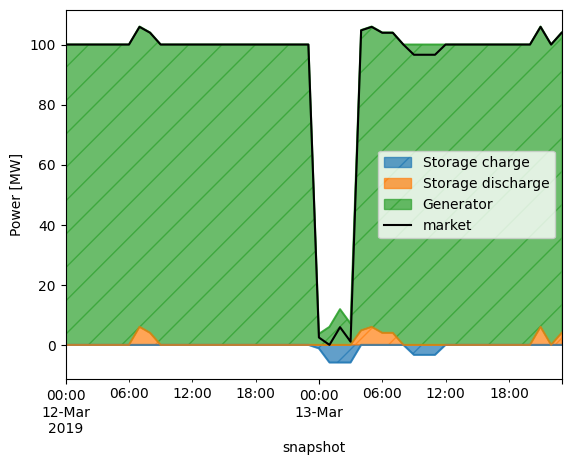

In [8]:
from matplotlib.dates import ConciseDateFormatter, AutoDateLocator

p_gen = n.generators_t.p["gen1"]
p_stu = n.storage_units_t.p["bat"]
p_market = -n.generators_t.p["da"]

# split the storage unit power into charging and discharging
p_stu_charge = p_stu.clip(upper=0)
p_stu_discharge = p_stu.clip(lower=0)

p_stacked = pd.concat([p_stu_charge, p_stu_discharge,p_gen], axis=1, keys=["Storage charge", "Storage discharge","Generator", ])
ax = p_stacked.plot.area(stacked=True, alpha=0.7)
for area in ax.collections:
    area.set_hatch('/')
p_market.plot(ax=ax, color="black", label="market")

ax.legend()
ax.set_ylabel("Power [MW]")

## Reserved Power

Text(0, 0.5, 'Negative Reserved Power [MW]')

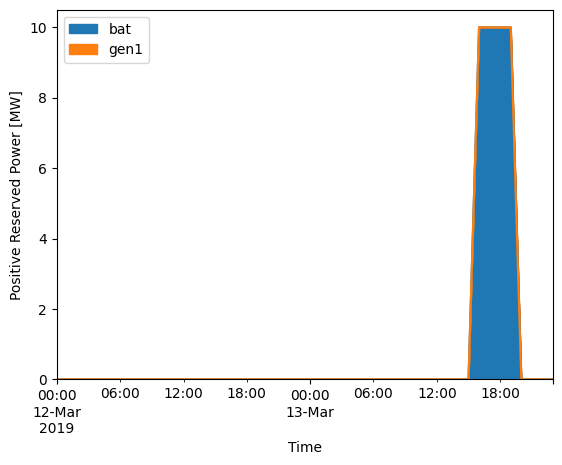

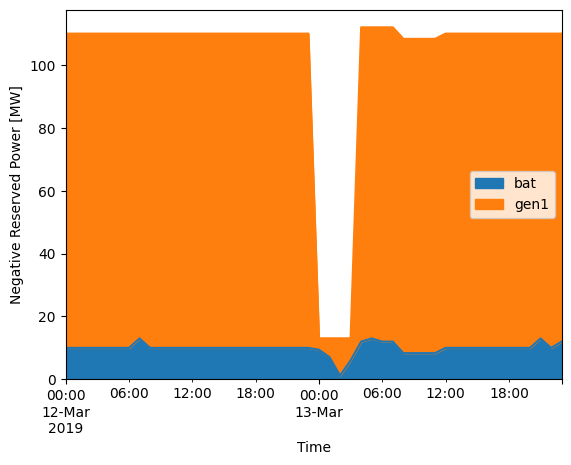

In [9]:
# index of Generators that are no power market

gen_idx = n.generators.index[~n.generators.is_market]
reserve_pos_gen = n.generators_t.reserve_pos[gen_idx]
reserve_neg_gen = n.generators_t.reserve_neg[gen_idx]
reserve_pos_stu = n.storage_units_t.reserve_pos
reserve_neg_stu = n.storage_units_t.reserve_neg

ax = reserve_pos_stu.join(reserve_pos_gen).plot.area(stacked=True)
ax.set_xlabel("Time")
ax.set_ylabel("Positive Reserved Power [MW]")

ax = reserve_neg_stu.join(reserve_neg_gen).plot.area(stacked=True)
ax.set_xlabel("Time")
ax.set_ylabel("Negative Reserved Power [MW]")